# Prediction Modeling Notebook

This notebook attempts to predict if a pollster will make the "right call" on a poll based on 538 poll data. Target was "rightcall" for all models. 

This notebook includes:

1. Baseline Analysis
2. Logistic Regression with Numeric Features (using StandardScaler and MinMaxScaler) 
3. Logistic Regression + Categorical Features (using StandardScaler) 
4. Simple Decision Tree (Cat + Num features)(using StandardScaler and MinMaxScaler)  - Best Model
5. Grid Search Decision Tree - (Numeric and Categorical) (StandardScaler)
6. Random Forest Model - (Numeric and Categorical) (StandardScaler)
7. Random Forest with Interaction Features using PolynomialFeatures
8. Analyzing our best model (RF) Performance by Partisan group

In [1]:
#imports
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split, cross_val_score
from model_evaluator import evaluation
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
polls = pd.read_csv('../data/raw-polls-updated.csv')
polls.columns

Index(['poll_id', 'question_id', 'race_id', 'year', 'race', 'location',
       'type_simple', 'type_detail', 'pollster', 'pollster_rating_id',
       'methodology', 'partisan', 'polldate', 'samplesize', 'cand1_name',
       'cand1_id', 'cand1_party', 'cand1_pct', 'cand2_name', 'cand2_id',
       'cand2_party', 'cand2_pct', 'cand3_pct', 'margin_poll', 'electiondate',
       'cand1_actual', 'cand2_actual', 'margin_actual', 'error', 'bias',
       'rightcall', 'advancedplusminus', 'comment', 'calc_bias', 'Rank',
       'Pollster', 'Pollster Rating ID', 'Polls Analyzed', 'AAPOR/Roper',
       'Banned by 538', 'Predictive Plus-Minus', '538 Grade',
       'Mean-Reverted Bias', 'Races Called Correctly', 'Misses Outside MOE',
       'Simple Average Error', 'Simple Expected Error', 'Simple Plus-Minus',
       'Advanced Plus-Minus', 'Mean-Reverted Advanced Plus-Minus',
       '# of Polls for Bias Analysis', 'Bias', 'House Effect',
       'Average Distance from Polling Average (ADPA)', 'Herding P

In [3]:
# Removing the unrated pollsters we identified earlier
unrated_pollsters = ['University of Maryland', 'Brigham Young University', 'Research America Inc.', 
                     'Insights West', 'Sacred Heart University', 'Hofstra University']

unrated_indices = []

for pollster in unrated_pollsters:
    unrated_indices += list(polls[polls['pollster'] == pollster].index)

polls = polls.drop(
    index = unrated_indices
    ).reset_index()# Resetting index fixes issues from dropping rows

In [4]:
#mapping out the grade values from B/C for a flag in each letter
def grade_mapper(grade):
   if grade == 'C/B':
       return grade
   elif grade in ['C+', 'C', 'C-','C/D', 'F']:
       return 'C+ or lower'
   else:
       return 'B- or higher'

In [5]:
#applying the grade value function
polls['538 Grade'] = polls['538 Grade'].apply(grade_mapper)

### 1. Baseline

In [6]:
polls['rightcall'].value_counts(normalize=True)

rightcall
1.0    0.783543
0.0    0.179358
0.5    0.037099
Name: proportion, dtype: float64

In [7]:
#0.5 represents a dead heat so imputing to 0
right_call_baseline = polls['rightcall'].map({1:1, 0:0, 0.5:0})
right_call_baseline.value_counts(normalize=True)

rightcall
1    0.783543
0    0.216457
Name: proportion, dtype: float64

We are trying to predict if a pollster is going to make a right call based on the other features in the data set like error, year, methodology, and more. We know from our EDA research that these variables did not have very strong relationships with the "rightcall" target. 

For our purposes, we will use 0.783593 as our baseline for the models. As you can see we have imputed the 0.5 values to 0. A value of 0.5 means that the pollster had two or more candidates tied for the lead and one of the tied candidates won, according to the fivethirtyeight.

### 2. Logistic Regression - Numeric Features; Target - "rightcall", MinMaxScaler/StandardScaler 

In [8]:
#choosing numeric variables
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [9]:
#train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [10]:
#trying two different scaling methods 
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [11]:
#trying two different scaling methods 
mm = MinMaxScaler()
X_train_mm = sc.fit_transform(X_train)
X_test_mm = sc.transform(X_test)

In [12]:
#fitting the min max scaled data first
lg = LogisticRegression()
lg.fit(X_train_mm,y_train)

LogisticRegression()

In [13]:
print(f"Cross val R2: {cross_val_score(lg, X_train_mm, y_train).mean()}")
print(f"Testing R2: {lg.score(X_test_mm, y_test)}")

Cross val R2: 0.7827754280231882
Testing R2: 0.7828916782891678


In [14]:
#now fitting the with StandardScaler
lg = LogisticRegression()
lg.fit(X_train_sc,y_train)

LogisticRegression()

In [15]:
print(f"Cross val R2: {cross_val_score(lg, X_train_sc, y_train).mean()}")
print(f"Testing R2: {lg.score(X_test_sc, y_test)}")

Cross val R2: 0.7827754280231882
Testing R2: 0.7828916782891678


accuracy: 0.7828916782891678
recall: 0.9994065281899109
precision: 0.7832558139534884
f1 score: 0.8782268578878749


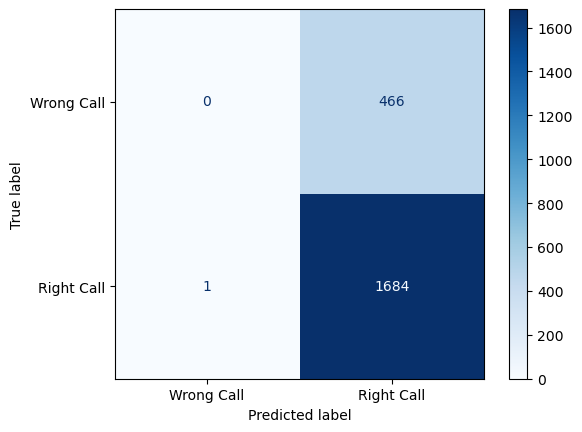

In [16]:
#making a confusion matrix
lg_org = evaluation(X_test_sc, y_test, lg);

With our baseline of .7836,  we can compare and see that both of these models (different scale methods) did not preform much better than the baseline, with a training score of around .7829 and a test score of .8000. Since our test score is higher than out training score, this is telling us that our model is underfit and we need to increase the complexity of our model. We now add in some categorical features to our model, including the features we created in our Cleaning process of this project (person,org,etc.)

We can see there was not a difference in using StandardScaler vs, MinMaxScaler for this Logistic Regression. 

### 3. Logistic Regression - Adding in Categorical Features; Target - "rightcall", StandardScaler 

In [17]:
#choosing the above variables plus categorical variables we can OHE
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',
           'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online', '538 Grade']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [19]:
#Pipe to encode cat variables like partisan and type of race, scaling the data with SS
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

lg_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple', '538 Grade'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('ss', StandardScaler()),
        ('logr', LogisticRegression())
    ]
)

In [20]:
lg_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan', 'type_simple',
                                                   '538 Grade'])])),
                ('ss', StandardScaler()), ('logr', LogisticRegression())])

In [21]:
#scores
print(f"Cross val R2: {cross_val_score(lg_pipe, X_train, y_train).mean()}")
print(f"Testing R2: {lg_pipe.score(X_test, y_test)}")

Cross val R2: 0.7810322554491036
Testing R2: 0.7838214783821479


accuracy: 0.7838214783821479
recall: 0.9952522255192878
precision: 0.7858481724461106
f1 score: 0.8782403770620582


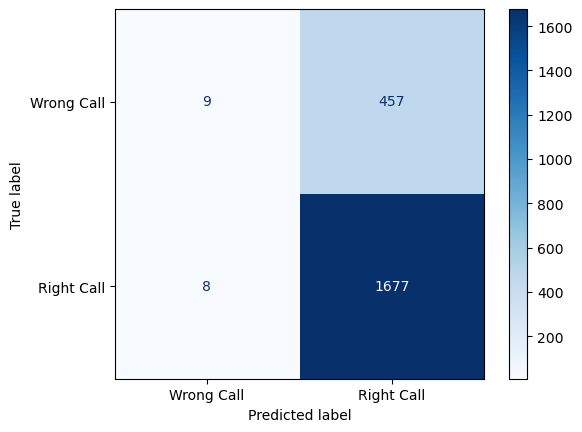

In [22]:
#making a confusion matrix
lg_cat = evaluation(X_test, y_test, lg_pipe);

With our baseline of .7836,  we can compare and see that adding in more categorical variables to make the model more complex did not help with a test score of 0.7838. We are now going to experiment with Decision Trees to see how this works as a model approach.

### 4. Simple Decision Tree - Same features as above (Numeric and Categorical) / StandardScaler v. MinMax

In [23]:
#choosing variables - same as above
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',
           'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online', '538 Grade']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [24]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [25]:
#Pipe to encode cat variables like partisan and type of race, scaling the data with SS
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

dt_pl1 = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple', '538 Grade'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('ss', StandardScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

In [26]:
dt_pl1.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan', 'type_simple',
                                                   '538 Grade'])])),
                ('ss', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [27]:
print(f"Cross val R2: {cross_val_score(dt_pl1, X_train, y_train).mean()}")
print(f"Testing R2: {dt_pl1.score(X_test, y_test)}")

Cross val R2: 0.8133429050173643
Testing R2: 0.8228730822873083


accuracy: 0.8228730822873083
recall: 0.8759643916913946
precision: 0.8956310679611651
f1 score: 0.8856885688568857


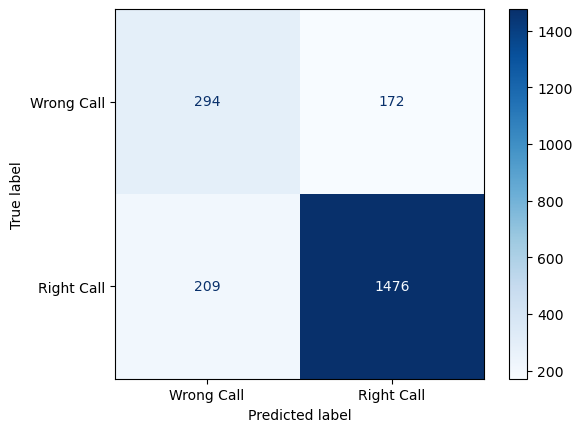

In [28]:
#making a confusion matrix
dt_1 = evaluation(X_test, y_test, dt_pl1);

Trying Single Dec. Tree MinMaxScaler to see if it helps the model before analyzing...

In [29]:
#choosing variables - same as above
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',
           'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online', '538 Grade']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8)

In [31]:
#Pipe to encode cat variables like partisan and type of race, scaling the data with MinMaxScaler
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

dt_pl2 = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple', '538 Grade'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('mm', MinMaxScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

In [32]:
dt_pl2.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan', 'type_simple',
                                                   '538 Grade'])])),
                ('mm', MinMaxScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [33]:
print(f"Cross val R2: {cross_val_score(dt_pl2, X_train, y_train).mean()}")
print(f"Testing R2: {dt_pl2.score(X_test, y_test)}")

Cross val R2: 0.8183419591097657
Testing R2: 0.8219432821943282


accuracy: 0.8219432821943282
recall: 0.8781785925487877
precision: 0.8935018050541517
f1 score: 0.8857739337906353


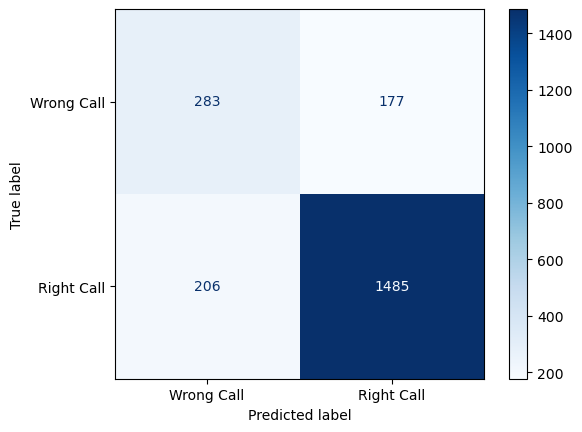

In [34]:
#making a confusion matrix
dt_2 = evaluation(X_test, y_test, dt_pl2);

We can see that Decision Tree modeling is working better than our baseline  with a 0.8229 accuracy score on the testing data and 0.8133 on the training data. Using StandardScaler v. MinMaxScaler made a very small improvement when using StandardScaler in the modeling. We can see the modeling, compared to logistic regression, is now guessing more "wrong calls" (instances when the polls were wrong), increasing the precision score and decreasing the recall score. It seems in earlier modeling attempts, the models were mostly guessing "right call" around 99 percent of the time, resulting in an accuracy score around 78 that was close to our baseline. Now we can see this model is working better to detect "wrong calls" using decision trees.

### 5. Grid Search Decision Tree - Same features as above (Numeric and Categorical) / StandardScaler

In [35]:
#choosing variables - same as above
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',
           'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online', '538 Grade']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [37]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

dt_pl3 = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple', '538 Grade'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('ss', StandardScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

In [38]:
                               
dt_grid = GridSearchCV(estimator=dt_pl3,
                   param_grid={'dt__max_depth' : [3, 5, 7, 10, None],
                              'dt__min_samples_split' : [2, 5, 10, 15, 20],
                               'dt__class_weight' : ["balanced", None],
                              'dt__min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7]},
                   cv = 5,
                   verbose=1)

In [39]:
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('patrisan_ct',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['partisan',
                                                                          'type_simple',
                                                                          '538 '
                                                                          'Grade'])])),
                                       ('ss', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__class_weight': ['balanced', None],
                         'dt__max_depth': [3, 5, 7, 10, None],
                         'dt__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'dt__min_samples_split': [2, 5, 10, 15, 20]},
             verbose=1)

In [40]:
dt_grid.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan', 'type_simple',
                                                   '538 Grade'])])),
                ('ss', StandardScaler()),
                ('dt',
                 DecisionTreeClassifier(min_samples_leaf=3,
                                        min_samples_split=20,
                                        random_state=42))])

In [41]:
dt_grid.best_score_

0.8238031566287853

We can see that Decision Tree modeling is still working really well with this data. Hypertuning our parameters did improve our accuracy score with an accuracy score of 0.8238 which is a little higher than our above decision tree. 

### 6. Random Forest Model

In [42]:
#choosing variables - same as above
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',
           'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online', '538 Grade']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [44]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

rf_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple', '538 Grade'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('mm', MinMaxScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ]
)

In [45]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan', 'type_simple',
                                                   '538 Grade'])])),
                ('mm', MinMaxScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

In [46]:
rf_cv_scores = cross_val_score(rf_pipe, X_train, y_train)
print(rf_cv_scores)
print(rf_cv_scores.mean())
print(rf_cv_scores.std())

[0.83846601 0.83091226 0.83846601 0.82858803 0.82965116]
0.833216693917814
0.004348759676623214


In [47]:
print(rf_pipe.score(X_test,y_test))

0.8386796838679684


We can see that random forest modeling is still working really well with this data and is now our best model with an accuracy score of 0.8387 (compared to our grid dt of 0.8238). 

### 7. Model with Interaction Features using PolynomialFeatures

In [48]:
#choosing variables - same as above
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',
           'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online', '538 Grade']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [50]:
partisaner = Pipeline( # OneHotEncodes race type and partisan
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

interaction_pipe = Pipeline(
    [
        ('poly', PolynomialFeatures(include_bias = False, interaction_only = True))
    ]
)

preprocessing_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple', '538 Grade']),
                ('features', interaction_pipe, ['Live Phone', 'IVR', 'Online', 'imputed_600', 'samplesize'])
            ],
            remainder = 'passthrough'
            )
        )
    ]
)

rf_polypipe = Pipeline(
    [
        ('pre', preprocessing_pipe),
        ('mm', MinMaxScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ]
)

In [51]:
rf_polypipe.fit(X_train,y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('patrisan_ct',
                                                                   Pipeline(steps=[('ohe',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['partisan',
                                                                    'type_simple',
                                                                    '538 '
                                                                    'Grade']),
                                                                  ('features',
                                                                   Pipeline(steps=[('poly',
                                                                                    PolynomialFeatures(include_bias=False,
                                                                                                       interaction_only=True))]),
                                                                   ['Live '
                                                                    'Phone',
                                                                    'IVR',
                                                                    'Online',
                                                                    'imputed_600',
                                                                    'samplesize'])]))])),
                ('mm', MinMaxScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

accuracy: 0.8279869827986983
recall: 0.941839762611276
precision: 0.8536847767616998
f1 score: 0.8955981941309255


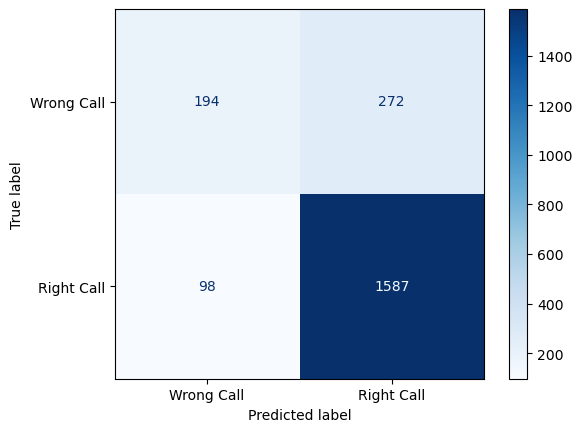

In [52]:
#making a confusion matrix
rf_poly = evaluation(X_test, y_test, rf_polypipe);

In [53]:
print(f"Cross val R2: {cross_val_score(rf_polypipe, X_train, y_train).mean()}")
print(f"Testing R2: {rf_polypipe.score(X_test, y_test)}")

Cross val R2: 0.8269405970028243
Testing R2: 0.8279869827986983


We explored some interaction effects we thought might be relevant to our model in an attempt to increase our complexity. We decided to use the three most popular polling methodologies (Live Phone, IVR, and Online), as well as both imputed600 and sample size because they're directly related. The methodologies were originally paired together on each row of data, ex. (Live Phone/Online) so we split up and mapped out that data, and now created interaction features. The "imputed_600" variable was extracted from the comment section of the polling data set in cases where the polling  sample size was imputed to 600. The feature interaction step did not increase our accuracy score from our best model of a .83 score.

### 8. Analyzing our best model (RF) Performance by Partisan group

accuracy: 0.8386796838679684
recall: 0.9471810089020771
precision: 0.86084142394822
f1 score: 0.9019497033060186


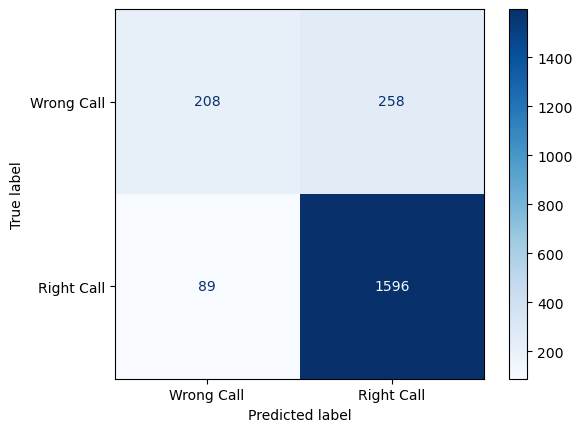

In [54]:
#overall CM 
rf_eval = evaluation(X_test, y_test, rf_pipe);

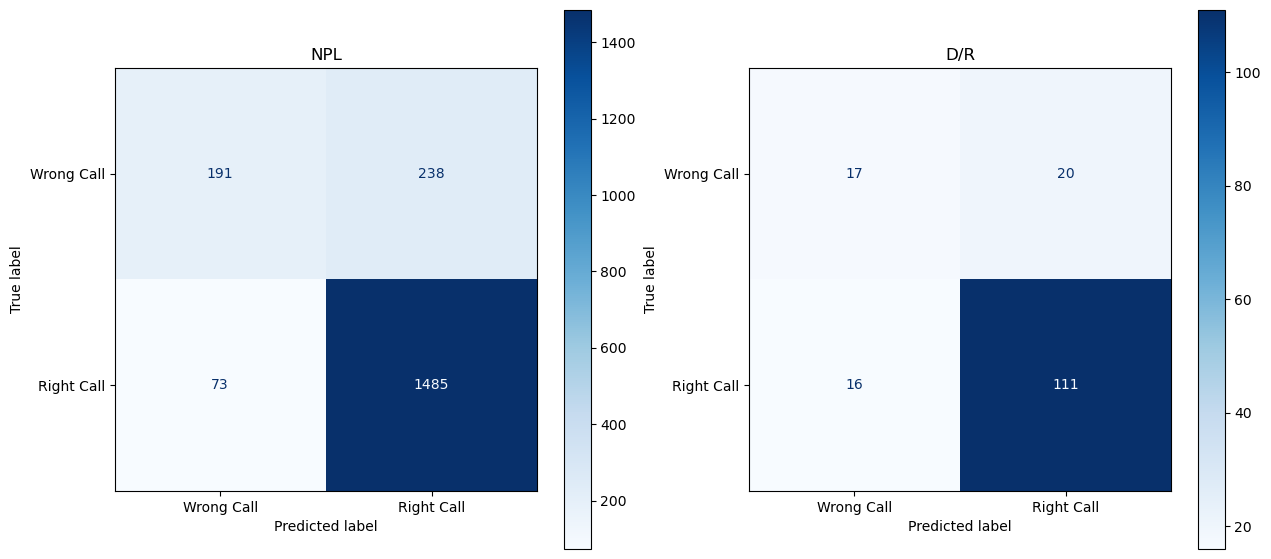

In [55]:
fig, ax  = plt.subplots(ncols = 2, figsize = (15, 7))

npl_index = X_test[X_test['partisan'] == 'NPL'].index
partisan_index = X_test[X_test['partisan'] != 'NPL'].index

ConfusionMatrixDisplay.from_estimator(rf_pipe, X_test.loc[npl_index], y_test.loc[npl_index], cmap = 'Blues', display_labels = ['Wrong Call', 'Right Call'], ax = ax[0])
ax[0].set_title('NPL')
ConfusionMatrixDisplay.from_estimator(rf_pipe, X_test.loc[partisan_index], y_test.loc[partisan_index], cmap = 'Blues', display_labels = ['Wrong Call', 'Right Call'], ax = ax[1])
ax[1].set_title('D/R');

accuracy: 0.8434826371414192
recall: 0.9531450577663672
precision: 0.8618688334300638
f1 score: 0.9052118256629077


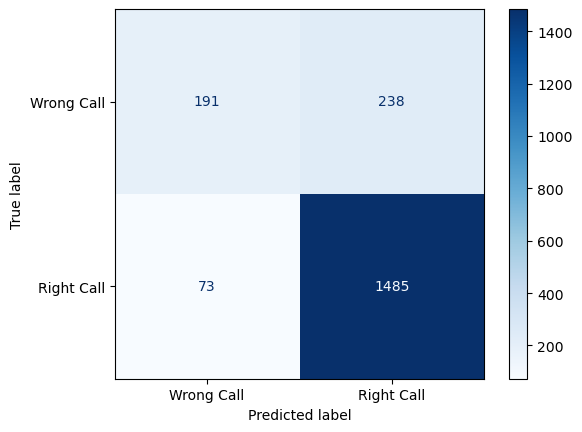

In [56]:
evaluation(X_test.loc[npl_index], y_test.loc[npl_index], rf_pipe);

accuracy: 0.7804878048780488
recall: 0.8740157480314961
precision: 0.8473282442748091
f1 score: 0.8604651162790697


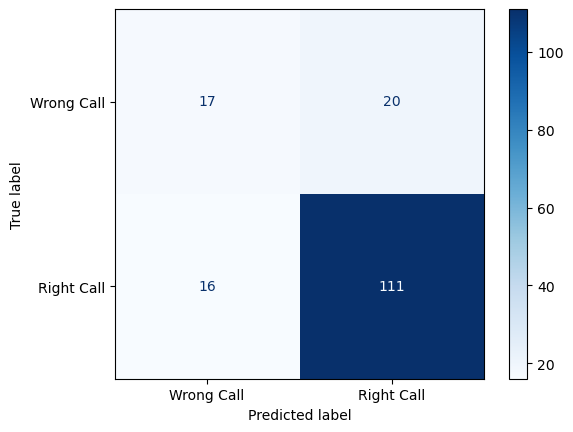

In [57]:
evaluation(X_test.loc[partisan_index], y_test.loc[partisan_index], rf_pipe);

In [58]:
polls['partisan'].value_counts()

partisan
NPL    9937
D       451
R       367
Name: count, dtype: int64

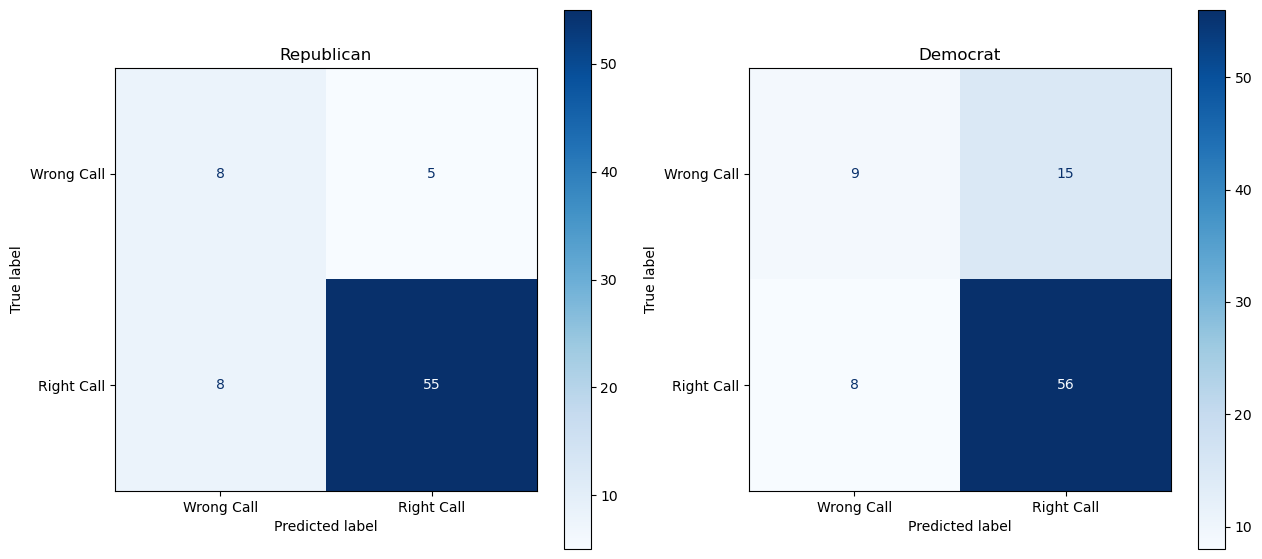

In [59]:
fig, ax  = plt.subplots(ncols = 2, figsize = (15, 7))

repub_index = X_test[X_test['partisan'] == 'R'].index
dem_index = X_test[X_test['partisan'] == 'D'].index

ConfusionMatrixDisplay.from_estimator(rf_pipe, X_test.loc[repub_index], y_test.loc[repub_index], cmap = 'Blues', display_labels = ['Wrong Call', 'Right Call'], ax = ax[0])
ax[0].set_title('Republican')
ConfusionMatrixDisplay.from_estimator(rf_pipe, X_test.loc[dem_index], y_test.loc[dem_index], cmap = 'Blues', display_labels = ['Wrong Call', 'Right Call'], ax = ax[1])
ax[1].set_title('Democrat');

accuracy: 0.8289473684210527
recall: 0.873015873015873
precision: 0.9166666666666666
f1 score: 0.894308943089431


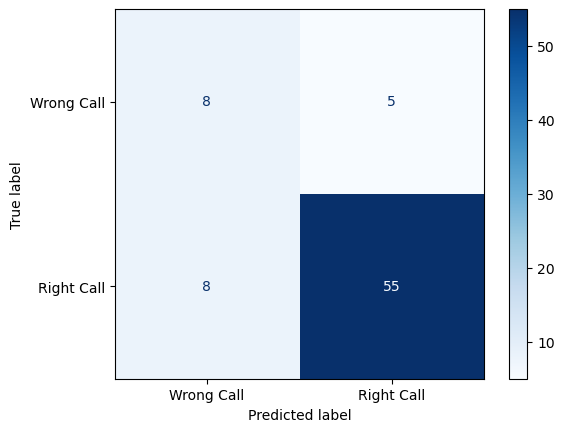

In [60]:
evaluation(X_test.loc[repub_index], y_test.loc[repub_index], rf_pipe);

accuracy: 0.7386363636363636
recall: 0.875
precision: 0.7887323943661971
f1 score: 0.8296296296296297


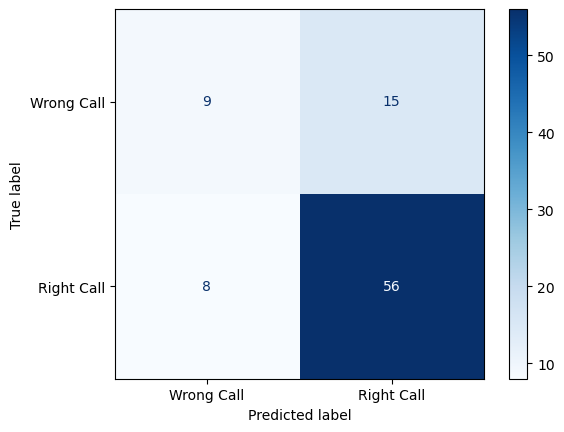

In [61]:
evaluation(X_test.loc[dem_index], y_test.loc[dem_index], rf_pipe);

We can see that the model is preforming better on the polls without party labels with an accuracy score of 0.8435 compared to polls with party labels (D/R) with an accuracy score of 0.7805. This is almost certainly because we have more polls with no party labels than we do of polls with partisan labels. However, we looked more into how the model preformed on Democrat v. Republican labeled polls and we found despite Democrat labeled data, the accuracy score related to Democrat labeled data was lower than the Republican labeled data. We do need to keep in mind that these counts are low, 451 Democrat labeled polls and 367 Republican labeled polls, so we will avoid making a large claim from this outcome, but it could be interesting analysis to see if this trend continues with more data with party labels.